In [1]:
from lcdb.db import LCDB
from lcdb.analysis.util import LearningCurveExtractor, merge_curves

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]

openmlid = 6
workflow = workflows[-1]

# retrieve learning curve objects
lcdb = LCDB()
df = lcdb.query(
    openmlids=[openmlid],
    workflows=[workflow],
    return_generator=False,
    processors={
        "learning_curve": LearningCurveExtractor(
            metrics=["error_rate"],
            folds=["train", "val"]
        )
    },
    show_progress=True
)

# group by configurations
#config_cols = [c for c in df.columns if c.startswith("p:")]
#df = df.groupby(config_cols).agg({"learning_curve": merge_curves})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.61s/it]


In [4]:
config_cols = [c for c in df.columns if c.startswith("p:")]
df = df.groupby(config_cols).agg({"learning_curve": merge_curves})

In [5]:
max_schedule = df["learning_curve"].iloc[0].anchors_size
print(max_schedule)

[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2896, 4096, 5793, 8192, 11585, 16000]


In [7]:
df["learning_curve"].apply(lambda x: x.pad_anchors_size(max_schedule, inplace=True))

p:bootstrap  p:criterion  p:max_depth  p:max_features  p:min_impurity_decrease  p:min_samples_leaf  p:min_samples_split  p:n_estimators  p:pp@cat_encoder  p:pp@decomposition  p:pp@featuregen  p:pp@featureselector  p:pp@scaler  p:splitter  p:max_samples  p:pp@kernel_pca_kernel  p:pp@kernel_pca_n_components  p:pp@poly_degree  p:pp@selectp_percentile  p:pp@std_with_std
False        entropy      9            all             0.089746                 16                  5                    512             onehot            none                poly             selectp               std          best        0.001000       linear                  0.250000                      2                 100                      True                 <lcdb.analysis.util.LearningCurve object at 0x...
                          25           log2            0.444497                 12                  37                   512             onehot            ka_rbf              poly             none             

In [8]:
df

learning_curve
p:bootstrap p:criterion p:max_depth p:max_features p:min_impurity_decrease p:min_samples_leaf p:min_samples_split p:n_estimators p:pp@cat_encoder p:pp@decomposition p:pp@featuregen p:pp@featureselector p:pp@scaler p:splitter p:max_samples p:pp@kernel_pca_kernel p:pp@kernel_pca_n_components p:pp@poly_degree p:pp@selectp_percentile p:pp@std_with_std                                                   
False       entropy     9           all            0.089746                16                 5                   512            onehot           none               poly            selectp              std         best       0.001000      linear                 0.250000                     2                100                     True               <lcdb.analysis.util.LearningCurve object at 0x...
                        25          log2           0.444497                12                 37                  512            onehot           ka_rbf             poly            none                 none        best       0.001000      linear                 0.250000                     2                25                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                        26          log2           0.534885                17                 28                  512            onehot           none               none            selectp              none        best       0.001000      linear                 0.250000                     2                48                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                        30          all            0.791019                24                 44                  512            onehot           kernel_pca         poly            selectp              none        best       0.001000      rbf                    0.807096                     2                38                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                        35          log2           0.772600                11                 13                  512            onehot           fastica            poly            selectp              minmax      random     0.001000      linear                 0.250000                     2                39                      True               <lcdb.analysis.util.LearningCurve object at 0x...
...                                                                                                                                                                                                                                                                                                                                                                                                          ...
True        log_loss    70          log2           0.560514                25                 44                  512            onehot           ka_nystroem        none            selectp              minmax      best       0.664912      linear                 0.250000                     2                25                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                        76          all            0.559352                24                 12                  512            ordinal          ka_rbf             none            none                 minmax      best       0.676648      linear                 0.250000                     2                25                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                        85          all            0.242263                3                  28                  512            onehot           fastica            none            none                 std         best       0.348522      linear                 0.250000                     2                25                      True               <lcdb.analysis.util.Learn

# Plot of learning curves

/tmp/ipykernel_739147/3668702167.py:8: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(lc, axis=(0, 1, 2)).squeeze()


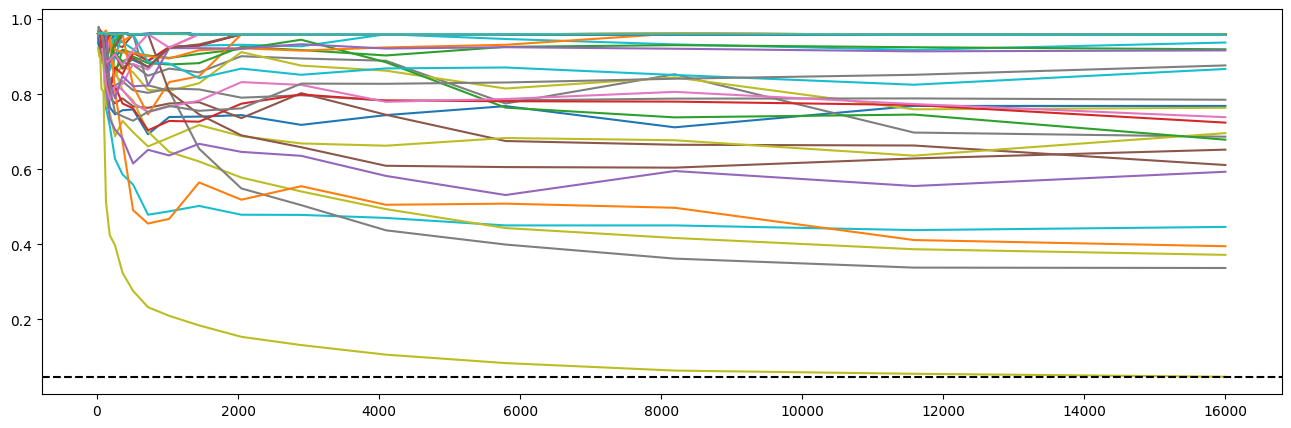

In [26]:
fig, ax = plt.subplots(figsize=(16, 5))
best_score = np.inf
for lc in df["learning_curve"]:
    schedule = lc.anchors_size
    lc = lc.values[0, 1, :, :, :, :, -1] if lc.is_iteration_wise_curve else lc.values[0, 1] # validation error rate
    
    if np.any(~np.isnan(lc)):
        mu = np.nanmean(lc, axis=(0, 1, 2)).squeeze()
        std = np.nanstd(lc, axis=(0, 1, 2)).squeeze()
        ax.plot(schedule, mu)
        ax.fill_between(schedule, mu - std, mu + std, alpha=0.1)
        if not np.isnan(mu[-1]) and mu[-1] < best_score:
            best_score = mu[-1]
    
ax.axhline(best_score, color="black", linestyle="--")
plt.show()

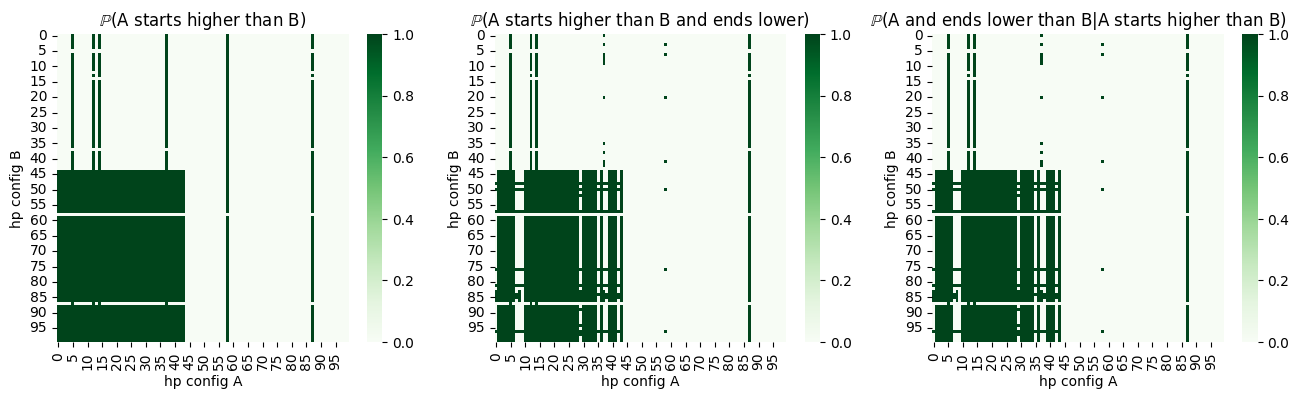

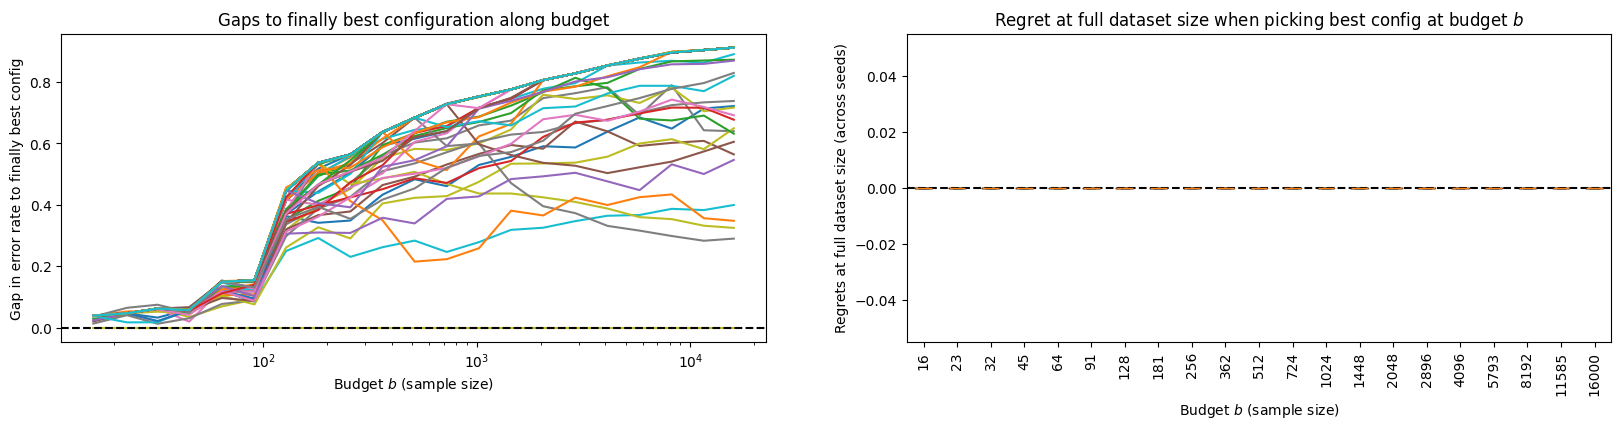

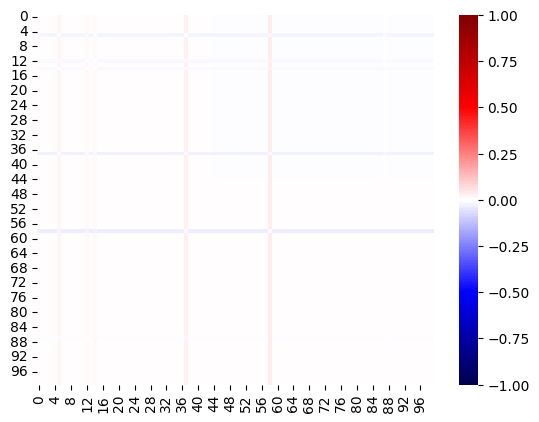

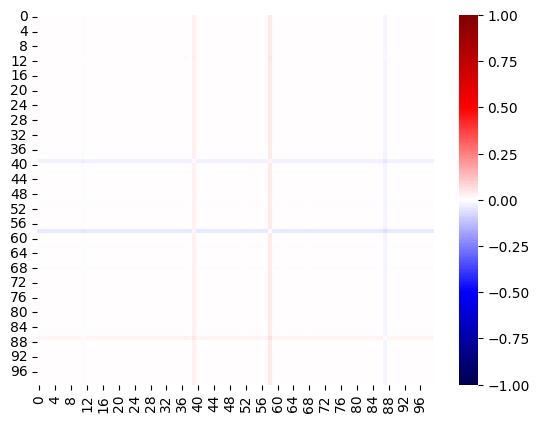

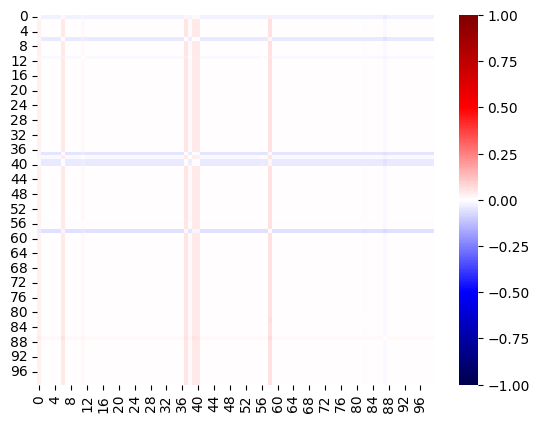

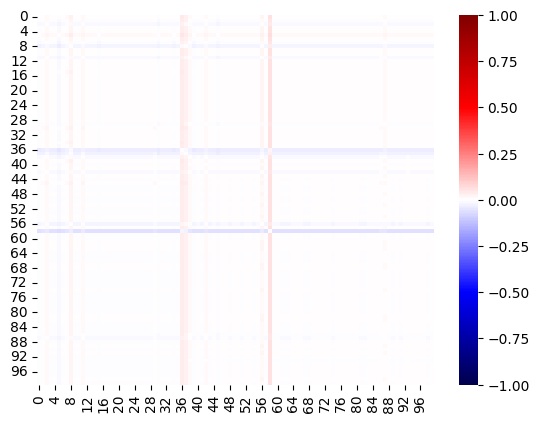

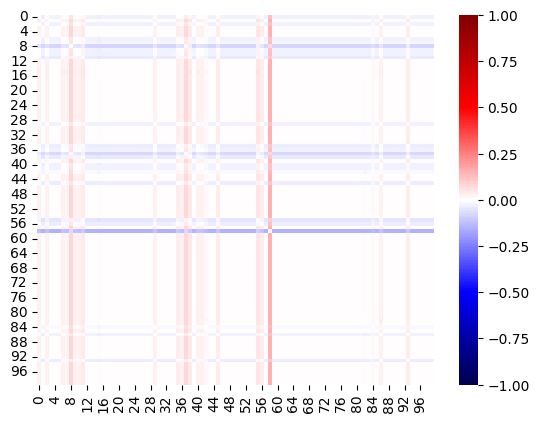

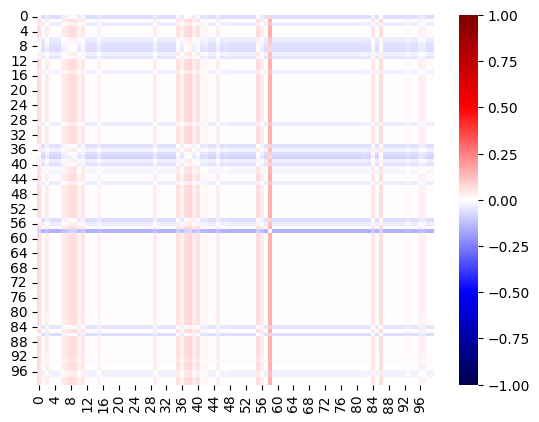

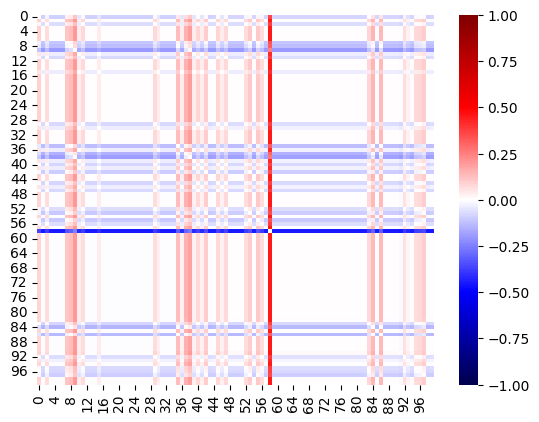

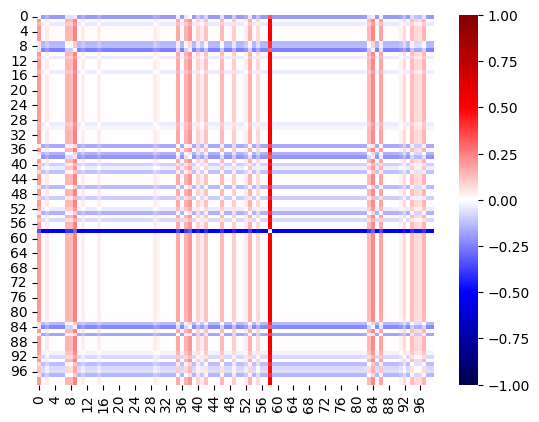

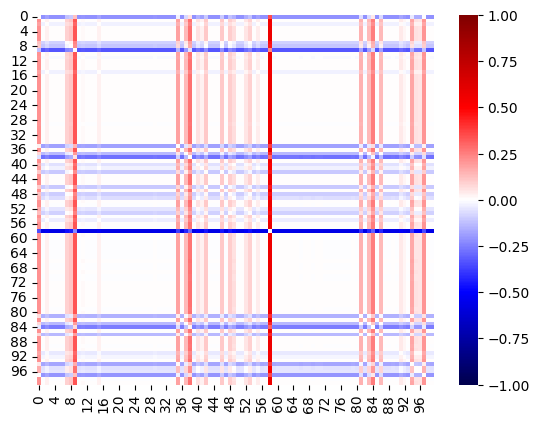

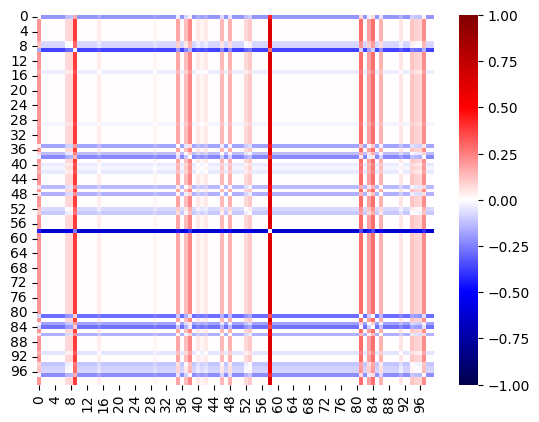

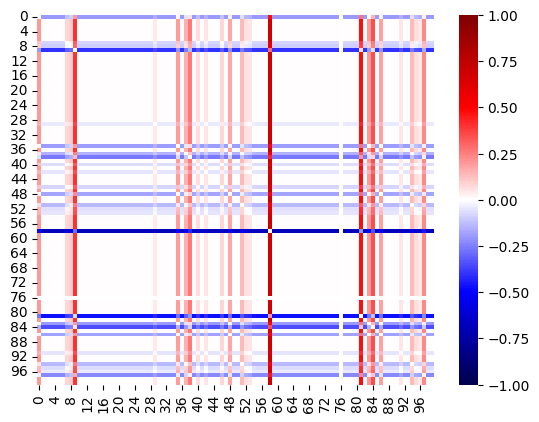

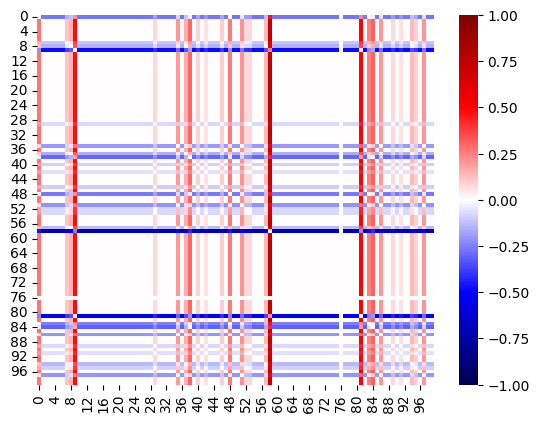

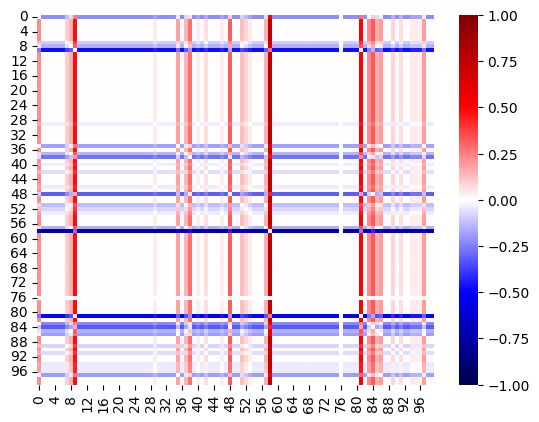

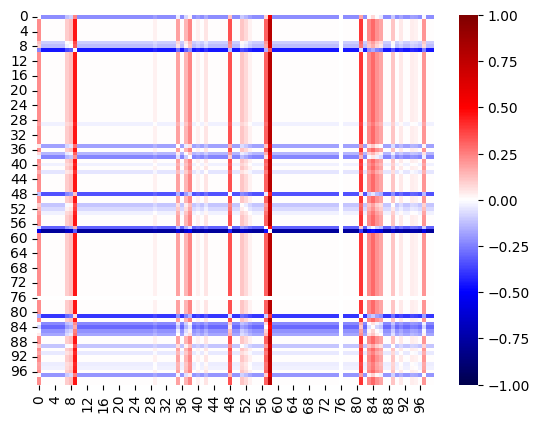

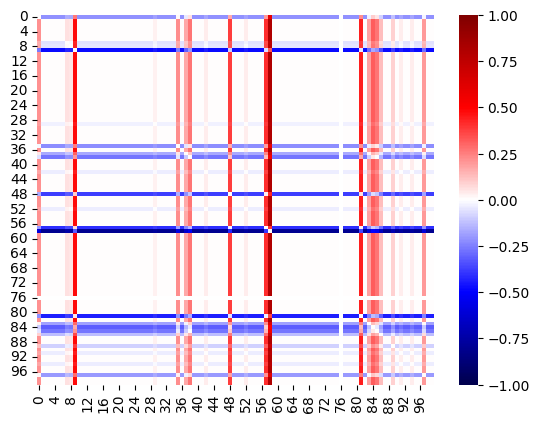

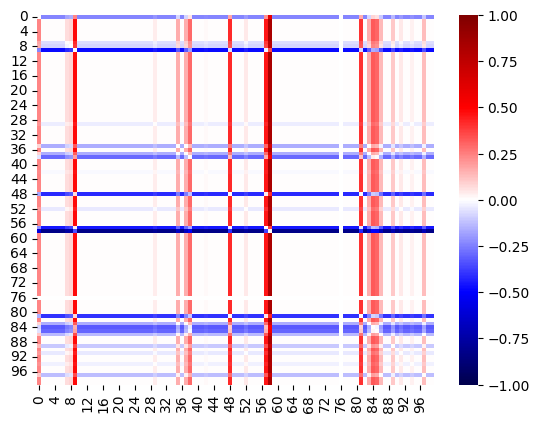

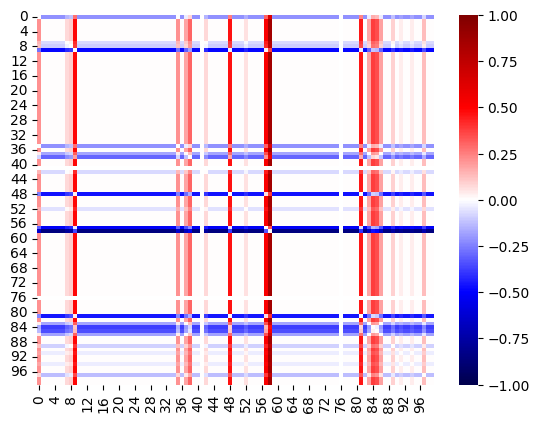

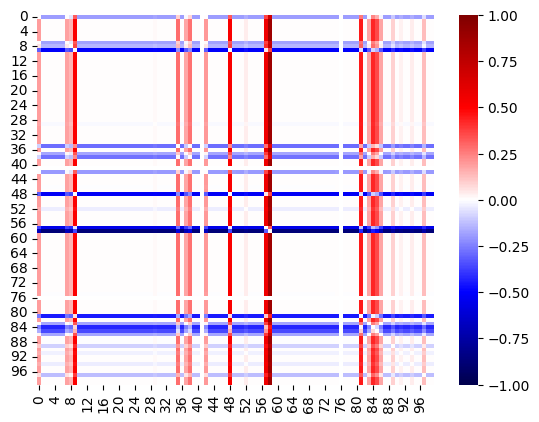

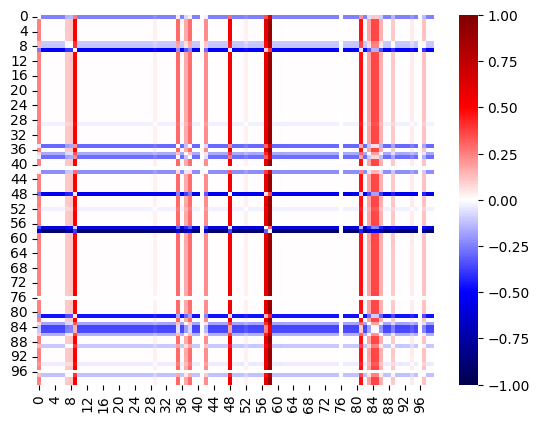

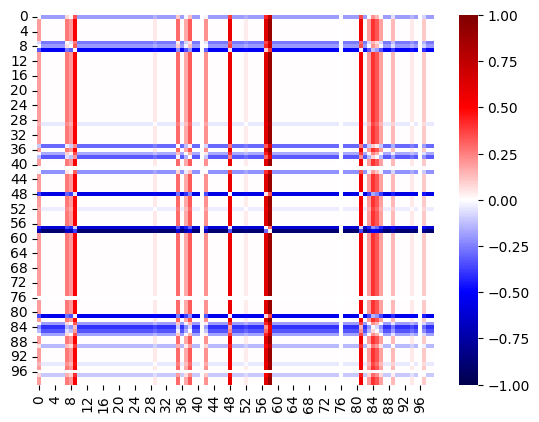

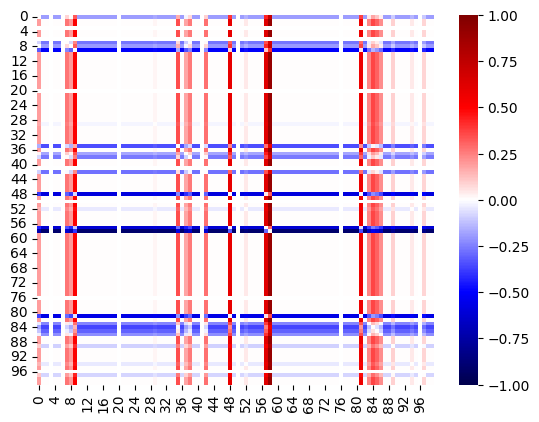

In [10]:
def learning_curve_crossing_evaluation(df):
    
    schedule = df["learning_curve"].iloc[0].anchors_size
    
    # compute diffs at different anchors
    diffs = np.zeros((len(df), len(df), len(df["learning_curve"].iloc[0].test_seeds), len(df["learning_curve"].iloc[0].val_seeds), len(df["learning_curve"].iloc[0].workflow_seeds), len(schedule)))
    for i, lc1 in enumerate(df["learning_curve"]):
        curve1 = lc1.values[0, 1, :, :, :, :, -1]
        for j, lc2 in enumerate(df["learning_curve"]):
            curve2 = lc2.values[0, 1, :, :, :, :, -1]
            diffs[i, j] = curve1 - curve2
    diffs_bin = diffs > 0
    
    # define start index
    start_index = 0
    
    # compute P(A starts lower than B)
    probs_a_starts_higher_than_b = diffs_bin[:,:,:,:,:,start_index].mean(axis=(2, 3, 4))
    
    # compute P(A starts lower than B and finishes higher)
    probs_a_strats_higher_than_b_and_ends_lower_than_b = (diffs_bin[:,:,:,:,:,start_index] & ~diffs_bin[:,:,:,:,:,-1]).mean(axis=(2, 3, 4))
    
    # figure for probability of crossing
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    sb.heatmap(probs_a_starts_higher_than_b, cmap="Greens", ax=axs[0])
    sb.heatmap(probs_a_strats_higher_than_b_and_ends_lower_than_b, cmap="Greens", ax=axs[1])
    sb.heatmap(probs_a_strats_higher_than_b_and_ends_lower_than_b / np.maximum(10**-10, probs_a_starts_higher_than_b), cmap="Greens", ax=axs[2])
    axs[0].set_title(r"$\mathbb{P}$(A starts higher than B)")
    axs[1].set_title(r"$\mathbb{P}$(A starts higher than B and ends lower)")
    axs[2].set_title(r"$\mathbb{P}$(A and ends lower than B|A starts higher than B)")
    for ax in axs:
        ax.set_xlabel("hp config A")
        ax.set_ylabel("hp config B")
    fig.savefig("plots/lc_crossing_liblinear.pdf", bbox_inches="tight")
    plt.show()
    
    # gaps to the finally best (at the respective budget)
    idx_of_best = np.argmin([np.nanmean(lc.values[0, 1, :, :, :, -1]) if np.count_nonzero(~np.isnan(lc.values[0, 1, :, :, :, -1])) > 0 else np.inf for lc in df["learning_curve"]])
    fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    ax = axs[0]
    for diff in diffs[:,idx_of_best]:
        mu = diff.mean(axis=(0, 1, 2))
        std = diff.std(axis=(0, 1, 2))
        ax.plot(schedule, mu)
        ax.fill_between(schedule, mu - std, mu + std, alpha=0.1)
    ax.axhline(0, color="black", linestyle="--")
    ax.set_title("Gaps to finally best configuration along budget")
    ax.set_xlabel("Budget $b$ (sample size)")
    ax.set_ylabel("Gap in error rate to finally best config")
    ax.set_xscale("log")
    
    # distribution of final gaps based on selections by budgets
    gaps_by_budget = {}
    for i, budget in enumerate(schedule):
        mean_scores_at_budget = []
        for lc in df["learning_curve"]:
            lc_slice = lc.values[0, 1, :, :, :, i]
            mean_scores_at_budget.append(np.nanmean(lc_slice) if np.count_nonzero(~np.isnan(lc_slice)) > 0 else np.inf)
        idx_of_best_at_budget = np.argmin(mean_scores_at_budget)
        gaps_by_budget[budget] = diffs[idx_of_best_at_budget,idx_of_best, :, :, :, -1].flatten()
        gaps_by_budget[budget] = gaps_by_budget[budget][~np.isnan(gaps_by_budget[budget])]
    ax = axs[1]
    ax.boxplot([gaps_by_budget[b] for b in schedule])
    ax.axhline(0, color="black", linestyle="--")
    ax.set_xticklabels(schedule, rotation=90)
    ax.set_title("Regret at full dataset size when picking best config at budget $b$")
    ax.set_xlabel("Budget $b$ (sample size)")
    ax.set_ylabel("Regrets at full dataset size (across seeds)")
    plt.show()
    
    # figures for diffs
    for i in range(len(schedule)):
        fig, ax = plt.subplots()
        sb.heatmap(diffs.mean(axis=(2, 3, 4))[:, :, i], ax=ax, vmin=-1, vmax=1, cmap="seismic")
        plt.show()
    
learning_curve_crossing_evaluation(df)